<a href="https://colab.research.google.com/github/abhishekshakya/BPSO-and-ANN-for-sofware-fault-predicition/blob/master/internPSO_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
#https://ieeexplore.ieee.org/abstract/document/8011255
#from SVM https://www.youtube.com/watch?v=_PwhiWxHK8o

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# !pip install -U skorch

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.io import arff
from sklearn.model_selection import cross_val_score
# from skorch import NeuralNetClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
df_pc1 = pd.read_csv('/content/drive/My Drive/dataset/pc1.csv')
df_kc1 = pd.read_csv('/content/drive/My Drive/dataset/kc1.csv')
df_kc2 = pd.read_csv('/content/drive/My Drive/dataset/kc2.csv')
df_jm1 = pd.read_csv('/content/drive/My Drive/dataset/jm1.csv')   

##Data cleaning

#####For kc2, here y feature is in object type

In [5]:
#for kc2 here change output feature from object -> bool
p = df_kc2['defects']
map = {'yes':True, 'no':False}
df_kc2['defects'] = p.map(map)


In [6]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

####For jm1, we have '?' randomly distributed so we need to remove them also

In [7]:
d1,d2,d3,d4,d5 = df_jm1.iloc[:,16], df_jm1.iloc[:,17], df_jm1.iloc[:,18], df_jm1.iloc[:,19], df_jm1.iloc[:,20]

for i in range(len(d1)):
  if (str)(d1[i]) == '?' or (str)(d2[i]) == '?' or (str)(d3[i]) == '?' or (str)(d4[i]) == '?' or (str)(d5[i]) == '?':
    df_jm1.drop(i,inplace=True)
    i -= 1


In [8]:
# print(x_real)
# print(y_real)

In [9]:
# plt.hist(df_pc1['defects'].values)
# c =  0
# for i in df_pc1['defects'].values:
#   if i == False:
#     c += 1
# print(c/len(df_pc1['defects'].values))

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
class ANN(nn.Module):
  def __init__(self,features, nodes1, nodes2):
    super().__init__()
    self.l1 = nn.Linear(features, nodes1)
    self.l2 = nn.Linear(nodes1, nodes2)
    self.l3 = nn.Linear(nodes2 ,1)

  def forward(self,x):
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = (self.l3(x))
    return torch.sigmoid((x))

class network:
  def __init__(self, nodes1, nodes2, dim, r):
    """nodes = number of neural nodes in first layer
       dim = number of features
       r = learning rate
      """
    self.ANN = ANN(dim, nodes1, nodes2)
    self.optim = optim.Adam(self.ANN.parameters(), lr=r)
    self.criterion = nn.BCELoss()

  def fit(self, x, y, iterations):
    ANN = self.ANN
    optimizer = self.optim
    criterion = self.criterion
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    # y = y.reshape(y.shape[0],1)
    self.losses = []
    for i in (range(iterations)):

      optimizer.zero_grad()
    
      y_pred = ANN(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)

      loss.backward()
      optimizer.step()
      self.losses.append(loss.item())
      # if i%((int)(iterations*0.05)) == 0:
      #   print(f"epoch {i}/{iterations}| loss=>{loss.item()}")
  
  def predict(self, x):
    ANN = self.ANN
    x = torch.from_numpy(x).float()
    y_ = ANN(x)
    y_ = y_.reshape(y_.shape[0])
    y_res = []
    for i in range(len(y_)):
      if y_[i] >= 0.5 :
        y_res.append(1)
      else:
        y_res.append(0)
    return y_res,y_.detach().cpu().numpy()

In [26]:
class PSO:
  def __init__(self,particles, dimensions, lb, ub, itrations, c1, c2, w, xr, yr, node1, node2, lr, epochs):
    self.node1 = node1
    self.node2 = node2
    self.lr = lr
    self.epochs = epochs
    
    self.xr = xr
    self.yr = yr
    self.lb = lb
    self.ub = ub
    self.p = particles
    self.d = dimensions
    self.n = itrations
    self.c1 = c1
    self.c2 = c2
    self.w = w
    self.fitness_value = np.zeros(particles)#p
    self.X = np.random.randint(2,size=(particles,dimensions))#pxd
    self.V = np.random.randint(2,size=(particles,dimensions))#pxd
    self.pbest = self.X#pxd
    self.gbest = np.zeros(dimensions)#d
    max = 0
    self.maxg = 0
    self.run()

  def sigmoid(self,x):
    return 1/(1+np.exp(-x))
  
  def count(self,x):
    c = np.sum(x)
    return c

  def fitness(self,x):
    x_train = []
    y_train = self.yr

    for i in range(self.d):
      if x[i] == 1:
        x_train.append(self.xr[:,i])

    x_train = np.array(x_train).reshape((self.xr.shape[0],-1))

    if x_train.shape[1] == 0:#no feature selected then return 0 acc
      return 0
    #Stratified K Fold cross Validation-----------------------------------------------
    kfold =StratifiedKFold(n_splits=10)
    cc = 0
    accs = []
    for train_index, test_index in kfold.split(x_train, y_train):
      cc += 1
      x_train_fold = x_train[train_index] 
      y_train_fold = y_train[train_index] 
      x_test_fold = x_train[test_index] 
      y_test_fold = y_train[test_index]
      # neural Networks --------------overfitting----------------
      # net = network(self.node1,self.node2, x_train_fold.shape[1], self.lr)
      # net.fit(x_train_fold, y_train_fold, self.epochs)
      # ans,_ = net.predict(x_test_fold)
      #----------------------------------------------------------
      #---------KNN----------------------------------------------
      clf = KNeighborsClassifier(2)
      clf.fit(x_train_fold, y_train_fold)
      ans = clf.predict(x_test_fold)
      #-------------------------------------------------------------

      acc = ((ans==y_test_fold).sum()*1.0)/len(ans)
      accs.append(acc)

    return np.array(accs).mean()

  def run(self):
    for itr in tqdm(range(self.n)):
      if itr%5 == 0:
        print(f"iterations {itr} | max acc achieved {self.maxg} using {self.count(self.gbest)} features")
      for i in range(self.p):
        fit = self.fitness(self.X[i])
        if fit > self.fitness_value[i]:
          self.pbest[i] = np.copy(self.X[i])
          self.fitness_value[i] = fit

        if fit > self.maxg:
          self.gbest = np.copy(self.X[i])
          self.maxg = fit

        if fit == self.maxg and (self.count(self.X[i]) < self.count(self.gbest)):
          self.gbest = np.copy(self.X[i])

      for p in range(self.p):
        for q in range(self.d):
          r1 = np.random.randn()
          r2 = np.random.randn()
          self.V[p][q] = self.w * self.V[p][q] + self.c1*r1*(self.pbest[p][q] - self.X[p][q]) + self.c2*r2*(self.gbest[q] - self.X[p][q])

          if self.V[p][q] > self.ub:
            self.V[p][q] = self.ub
          if self.V[p][q] < self.lb:
            self.V[p][q] = self.lb

          if self.sigmoid(self.V[p][q]) > np.random.uniform(0,1):
            self.X[p][q] = 1
          else:
            self.X[p][q] = 0

      if fit == 1.0: #stop when acc is 100
          return
        


In [27]:
def get(p, lb, ub, it, c1, c2, w, node1, node2, lr, epochs, df):
  x = df.iloc[:,:-1].apply(func= normalize, axis=0).values
  y = df.iloc[:,-1].values.astype(int)

  pp = PSO(p,x.shape[1],lb,ub,it,c1,c2,w, x, y,node1,node2,lr,epochs)

  return pp

def ROC_curve(df,node1, node2, lr, epochs, name, pp):
  x = df.iloc[:,:-1].apply(func= normalize, axis=0).values
  y = df.iloc[:,-1].values.astype(int)
  x_ruc = []
  for i in range(len(pp.gbest)):
    if pp.gbest[i] == 1:
      x_ruc.append(x[:,i])
  
  x_ruc = np.array(x_ruc).reshape((x.shape[0],-1))

  # #------------------------------------------------ROC curve---------------------------------------
  print(f"for {name}")
  print(f"number of features selected {x_ruc.shape[1]}")

  # clf = RandomForestClassifier()
  # clf.fit(x_ruc,y)
  # y2_prob = clf.predict_proba(x_ruc)

  net = network(node1,node2, x_ruc.shape[1], lr)
  net.fit(x_ruc, y, epochs)
  prediction2, y2_prob = net.predict(x_ruc) 
  print(f"accuracy->{100*(((prediction2==y).sum()*1.0)/len(y))}")
  # print(y2_prob)
  fpr, tpr, _= metrics.roc_curve(y,y2_prob)
  auc = metrics.roc_auc_score(y,y2_prob)
  plt.title("ROC")
  plt.plot(fpr,tpr,label='auc: '+str(auc))
  plt.legend(loc=4)
  plt.show()
  plt.title("Erorr Loss")
  plt.plot(net.losses)
  plt.show()

In [28]:
p = 20 #number of particles
lb = -1 #min value for velocity 
ub = 1 #max value for velocity 
it = 100 #number of itrations
c1 = 2 # coefficient 1
c2 = 2 # coefficient 3
w = 0.4 #inertia

node1 = 4 #total number of nodes in layer1
node2 = 2 #total number of nodes in layer2
lr = 0.0016 #learning rate
epochs = 50 #epochs in ANN
pso = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_pc1)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.9314905814905815 using 8 features
iterations 10 | max acc achieved 0.9314905814905815 using 8 features
iterations 15 | max acc achieved 0.9387141687141687 using 11 features
iterations 20 | max acc achieved 0.9387141687141687 using 11 features
iterations 25 | max acc achieved 0.9387141687141687 using 11 features
iterations 30 | max acc achieved 0.9387141687141687 using 11 features
iterations 35 | max acc achieved 0.9387141687141687 using 11 features
iterations 40 | max acc achieved 0.9387141687141687 using 11 features
iterations 45 | max acc achieved 0.9387141687141687 using 11 features
iterations 50 | max acc achieved 0.9387141687141687 using 11 features
iterations 55 | max acc achieved 0.9387141687141687 using 11 features
iterations 60 | max acc achieved 0.9387141687141687 using 11 features
iterations 65 | max acc achieved 0.9387141687141687 using 11 features
iterations 70 | max acc achieved 0.93871

for pc1
number of features selected 11
accuracy->94.22903516681696


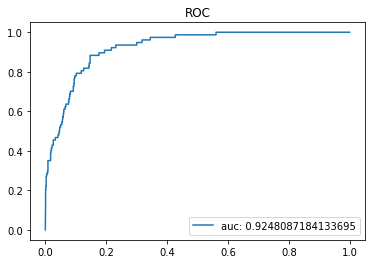

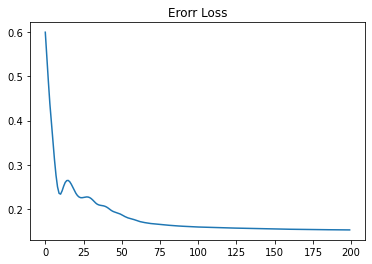

In [29]:
ROC_curve(df_pc1, 4, 2, 0.06, 200,"pc1",pso)

In [30]:
pso2 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc1)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.8928187767998195 using 7 features
iterations 10 | max acc achieved 0.8928187767998195 using 7 features
iterations 15 | max acc achieved 0.9018122320018056 using 7 features
iterations 20 | max acc achieved 0.9018122320018056 using 7 features
iterations 25 | max acc achieved 0.9018122320018056 using 7 features
iterations 30 | max acc achieved 0.9018122320018056 using 7 features
iterations 35 | max acc achieved 0.9018122320018056 using 7 features
iterations 40 | max acc achieved 0.9018122320018056 using 7 features
iterations 45 | max acc achieved 0.9018122320018056 using 7 features
iterations 50 | max acc achieved 0.9018122320018056 using 7 features
iterations 55 | max acc achieved 0.9018122320018056 using 7 features
iterations 60 | max acc achieved 0.9018122320018056 using 7 features
iterations 65 | max acc achieved 0.9018122320018056 using 7 features
iterations 70 | max acc achieved 0.9127849243962988

for kc1
number of features selected 6
accuracy->84.54243717401611


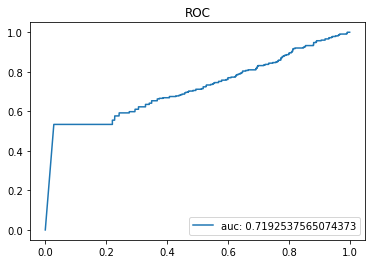

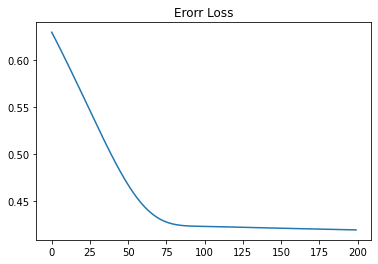

In [39]:
ROC_curve(df_kc1, 4, 2, 0.006, 200,"kc1",pso2)

In [40]:
pso3 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc2)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.8275036284470246 using 9 features
iterations 10 | max acc achieved 0.8275036284470246 using 9 features
iterations 15 | max acc achieved 0.8275036284470246 using 9 features
iterations 20 | max acc achieved 0.8602685050798259 using 12 features
iterations 25 | max acc achieved 0.8602685050798259 using 12 features
iterations 30 | max acc achieved 0.8912191582002903 using 7 features
iterations 35 | max acc achieved 0.8912191582002903 using 7 features
iterations 40 | max acc achieved 0.8912191582002903 using 7 features
iterations 45 | max acc achieved 0.8912191582002903 using 7 features
iterations 50 | max acc achieved 0.8912191582002903 using 7 features
iterations 55 | max acc achieved 0.8912191582002903 using 7 features
iterations 60 | max acc achieved 0.8912191582002903 using 7 features
iterations 65 | max acc achieved 0.8912191582002903 using 7 features
iterations 70 | max acc achieved 0.89121915820029

for kc2
number of features selected 5
accuracy->92.72030651340997


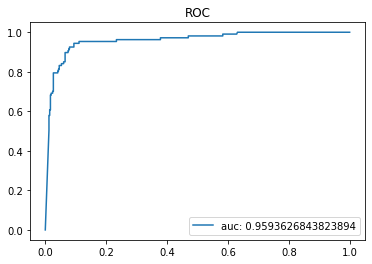

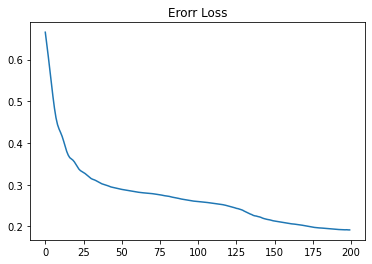

In [41]:
ROC_curve(df_kc2, 4, 2, 0.06, 200,"kc2",pso3)

In [42]:
pso4 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_jm1)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.8773897058823531 using 9 features
iterations 10 | max acc achieved 0.8773897058823531 using 9 features
iterations 15 | max acc achieved 0.8773897058823531 using 9 features
iterations 20 | max acc achieved 0.8773897058823531 using 9 features
iterations 25 | max acc achieved 0.8773897058823531 using 9 features
iterations 30 | max acc achieved 0.8773897058823531 using 9 features
iterations 35 | max acc achieved 0.8856617647058822 using 8 features
iterations 40 | max acc achieved 0.8856617647058822 using 8 features
iterations 45 | max acc achieved 0.8856617647058822 using 8 features
iterations 50 | max acc achieved 0.8856617647058822 using 8 features
iterations 55 | max acc achieved 0.8856617647058822 using 8 features
iterations 60 | max acc achieved 0.8856617647058822 using 8 features
iterations 65 | max acc achieved 0.8856617647058822 using 8 features
iterations 70 | max acc achieved 0.8856617647058822

for jmq
number of features selected 10
accuracy->92.44485294117646


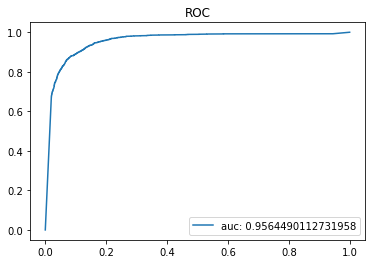

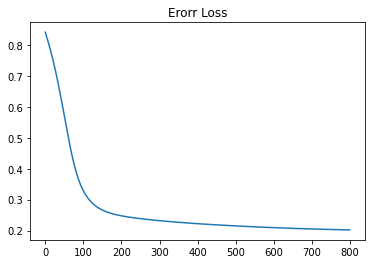

In [47]:
ROC_curve(df_jm1, 4, 2, 0.006, 800,"jmq",pso4)